In [3]:
!pip3 install torch torchvision
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [38]:
data = pd.read_csv('fer2013.csv')
data.shape

(35887, 3)

In [0]:
width, height = 48, 48

train_images = []
test_images = []
train_labels = []
test_labels = []
train_data = []
test_data = []
for index,row in data.iterrows():
    pixels=np.asarray(list(row['pixels'].split(' ')),dtype=np.uint8)
    img=pixels.reshape((width,height))
    if row['Usage'] == 'Training':
      train_labels.append(row['emotion'])
      train_images.append(img)
      train_data.append(img)
      #train_data.append(row['emotion'])
    else :
      test_labels.append(row['emotion'])
      test_images.append(img)
      test_data.append(img)
      #test_data.append(row['emotion'])

for index,row in data.iterrows():
  if row['Usage'] == 'Training':
    train_data.append(row['emotion'])
  else :
    test_data.append(row['emotion'])

In [0]:

BATCH_SIZE = 100
#batch_size = 100

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        #self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
    
        if self.transform:
            #x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        return self

transform = transforms.Compose([transforms.ToTensor()])



In [0]:
trainset = MyDataset(train_images,train_labels, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE)#, shuffle=True, num_workers=2)

In [42]:
len(trainset)

28709

In [0]:
testset = MyDataset(test_images, test_labels, transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)#, shuffle=False, num_workers=2)

In [0]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [45]:
len(images)

100

In [0]:
def imshow(img):
    #img = img / 2 + 0.5     
    npimg = img.numpy()
    print(npimg.shape)
    print(np.transpose(npimg).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

(3, 652, 402)
(402, 652, 3)


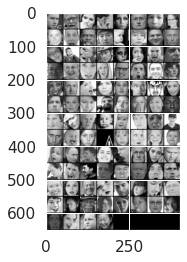

In [47]:
imshow(torchvision.utils.make_grid(images))

In [0]:
#LR model
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

In [0]:

n_iters = 3000
N_EPHOCS = 1500
epochs = 50
input_dim = 2304
output_dim = 7
lr_rate = 0.001

In [0]:
model = LogisticRegression(input_dim, output_dim)

In [74]:
# Testing the model
      
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = LogisticRegression(input_dim, output_dim)
#logits = model(Variable(images.view(-1, 48*48)))
logits = model(images.view(-1, 48*48))
print(logits[0:7])

tensor([[-0.3229,  0.0300, -0.0374,  0.0345, -0.2498,  0.2055,  0.3662],
        [-0.3517, -0.0180, -0.2762,  0.1317, -0.2335,  0.1456,  0.1031],
        [-0.2099, -0.1686,  0.0353,  0.2692, -0.3809,  0.1846,  0.1773],
        [-0.1088, -0.3413, -0.0548,  0.0260, -0.1979,  0.0749, -0.1693],
        [-0.2854, -0.1413, -0.0727, -0.0794, -0.2607,  0.2892,  0.2842],
        [-0.4478, -0.0742, -0.0949,  0.0103, -0.3453,  0.2078,  0.1126],
        [-0.1826, -0.3014, -0.1355, -0.0602, -0.0135,  0.2317,  0.1531]],
       grad_fn=<SliceBackward>)


In [0]:
# Training the model
   
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = LogisticRegression(input_dim, output_dim)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [76]:
for epoch in range(N_EPHOCS):  # loop over the dataset multiple times
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        #model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        #inputs = Variable(inputs.view(-1, 48*48)) 
        inputs = inputs.view(-1, 48*48) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
         %(epoch, train_running_loss/i, train_acc/i))
# print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' 
#           %(epoch, train_running_loss/i, train_acc/i))    


# TEST ACCURACY
test_acc = 0.0
predict = []
label = []
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    #inputs = Variable(inputs.view(-1, 48*48)) 
    inputs = inputs.view(-1, 48*48) 

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)

    preds = torch.argmax(outputs, 1)
    pred = preds.tolist()
    lab = labels.tolist()
    predict.extend(pred)
    label.extend(lab)

        
print('Test Accuracy: %.2f'%(test_acc / i))


Epoch: 0 | Loss: 1.8288 | Train Accuracy: 24.84
Epoch: 1 | Loss: 1.8007 | Train Accuracy: 25.93
Epoch: 2 | Loss: 1.7872 | Train Accuracy: 26.78
Epoch: 3 | Loss: 1.7766 | Train Accuracy: 27.79
Epoch: 4 | Loss: 1.7677 | Train Accuracy: 28.62
Epoch: 5 | Loss: 1.7599 | Train Accuracy: 29.49
Epoch: 6 | Loss: 1.7530 | Train Accuracy: 30.20
Epoch: 7 | Loss: 1.7468 | Train Accuracy: 30.76
Epoch: 8 | Loss: 1.7411 | Train Accuracy: 31.26
Epoch: 9 | Loss: 1.7360 | Train Accuracy: 31.79
Epoch: 10 | Loss: 1.7313 | Train Accuracy: 32.18
Epoch: 11 | Loss: 1.7270 | Train Accuracy: 32.55
Epoch: 12 | Loss: 1.7230 | Train Accuracy: 32.90
Epoch: 13 | Loss: 1.7193 | Train Accuracy: 33.20
Epoch: 14 | Loss: 1.7158 | Train Accuracy: 33.50
Epoch: 15 | Loss: 1.7126 | Train Accuracy: 33.72
Epoch: 16 | Loss: 1.7096 | Train Accuracy: 33.94
Epoch: 17 | Loss: 1.7067 | Train Accuracy: 34.08
Epoch: 18 | Loss: 1.7041 | Train Accuracy: 34.26
Epoch: 19 | Loss: 1.7016 | Train Accuracy: 34.37
Epoch: 20 | Loss: 1.6992 | Tra

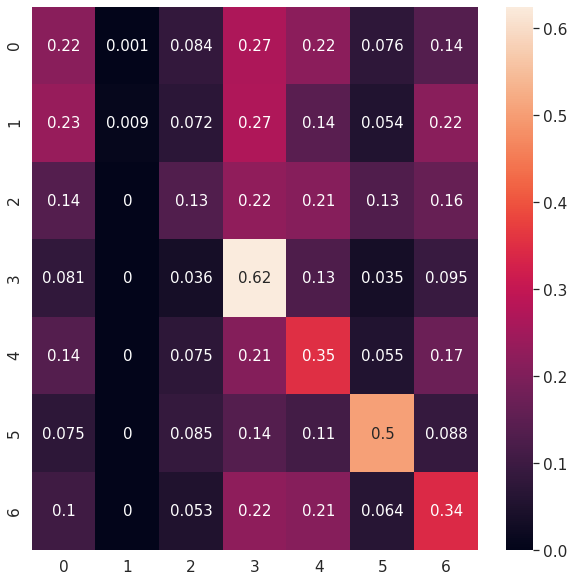

In [77]:
cm = confusion_matrix(label,predict,normalize="true")
#cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
df_cm = pd.DataFrame(cm,range(cm.shape[0]),range(cm.shape[1]))
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 15})